<a href="https://colab.research.google.com/github/msuriya2001/machine-learning-lab-exercises/blob/main/labex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
!wget : http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

:: Scheme missing.
--2022-06-12 05:09:05--  http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   293KB/s    in 0.7s    

2022-06-12 05:09:06 (293 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

FINISHED --2022-06-12 05:09:06--
Total wall clock time: 1.4s
Downloaded: 1 files, 199K in 0.7s (293 KB/s)


In [3]:
!unzip smsspamcollection.zip

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None)

In [6]:
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
import numpy as np

In [8]:
#replacing the values for "ham" = 0 and "span" = 1 

for i in range(5572):
    if df[0][i] == "ham":
        df[0][i] = 0
    else:
        df[0][i] = 1


In [9]:
y = np.asarray(df[0]).astype('float32')

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[1], y, test_size = 0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.8)

In [10]:
raw_train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
raw_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
raw_valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

In [11]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(
        stripped_html,
        f'[{re.escape(string.punctuation)}]',
        ''
    )

In [12]:
# forming text to vector 
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
vectorize_layer.adapt(raw_train_dataset.map(lambda x, y: x))

In [13]:
def vectorize_text(text,label):
    text = tf.expand_dims(text,-1) # add an extra dimension to the text 
    return vectorize_layer(text),label

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = raw_train_dataset.batch(32).map(vectorize_text).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_valid_dataset.batch(32).map(vectorize_text).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_dataset.batch(32).map(vectorize_text).cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [16]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])




In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [24]:
history = model.fit(train_ds, epochs=30,
                    validation_data=val_ds,
                  )

Epoch 1/10
112/112 [==============================] - 25s 93ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.1033 - val_accuracy: 0.9821
Epoch 2/10
112/112 [==============================] - 7s 46ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0977 - val_accuracy: 0.9854
Epoch 3/10
112/112 [==============================] - 7s 46ms/step - loss: 0.0043 - accuracy: 0.9994 - val_loss: 0.1087 - val_accuracy: 0.9832
Epoch 4/10
112/112 [==============================] - 7s 47ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.1076 - val_accuracy: 0.9877
Epoch 5/10
112/112 [==============================] - 7s 47ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1167 - val_accuracy: 0.9832
Epoch 6/10
112/112 [==============================] - 9s 60ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1203 - val_accuracy: 0.9843
Epoch 7/10
112/112 [==============================] - 7s 46ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1239 - val_accuracy: 0.985

In [25]:
history = history.history

In [26]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

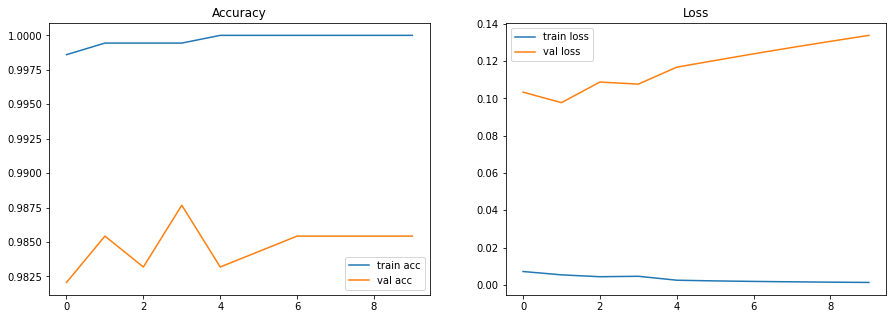

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()